In [93]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
path1 = r"C:\Users\abebe\Documents\George Mason University\6- SUMME 2023\Team-SkySci-Analytics\Metadata Merge Transform\ground_weather_merged.csv"
path2 = r"C:\Users\abebe\Documents\George Mason University\6- SUMME 2023\Team-SkySci-Analytics\Atmospheric Data Scraper\atmospheric_data_dewPt_master.csv"

In [97]:
atmosphericData = pd.read_csv(path2)
groundWeatehrData = pd.read_csv(path1)
atmosphericData.head()
# pressure units seems like is in units of pascal, which we will convert to hpa

,Timestamp,Latitude,Longitude,Temperature,Humidity,Pressure,Dew Point Temperature
0,9/1/2022 0:00,38.961388,-76.034706,209.432175,3.294195,16699.99771,288.57724
1,9/1/2022 0:00,38.423821,-77.731833,208.932175,3.669195,17099.99771,289.20224
2,9/1/2022 0:00,38.401123,-77.507117,208.807175,3.669195,17199.99771,288.88974
3,9/1/2022 0:00,38.622260,-77.928180,209.619675,3.169195,16599.99771,288.32724
4,9/1/2022 0:00,38.599837,-77.703001,209.369675,3.294195,16799.99771,288.76474


In [98]:
atmosphericData['Timestamp'] = pd.to_datetime(atmosphericData['Timestamp'], format='%m/%d/%Y %H:%M').dt.strftime('%Y-%m-%d %H:%M:%S')

In [99]:
# Group the DataFrame by longitude and latitude
grouped_data = atmosphericData.groupby(['Longitude', 'Latitude'])

# Iterate over the groups
for group, group_df in grouped_data:
# Print longitude, latitude, and the corresponding data for each group to look at all the available coordinates
    print("Longitude:", group[0])
    print("Latitude:", group[1])
    print("Grouped data:")
    print(group_df)
    print()

Longitude: -77.95664428
Latitude: 38.44622425
Grouped data:
                  Timestamp   Latitude  Longitude  Temperature  Humidity  \
14      2022-09-01 00:00:00  38.446224 -77.956644   209.182175  3.544195   
33      2022-09-01 00:00:00  38.446224 -77.956644   209.428589  3.286933   
64      2022-09-01 01:00:00  38.446224 -77.956644   209.119629  3.543959   
68      2022-09-01 01:00:00  38.446224 -77.956644   209.144486  3.555294   
187     2022-09-01 02:00:00  38.446224 -77.956644   208.814514  3.565333   
...                     ...        ...        ...          ...       ...   
173389  2022-12-22 21:00:00  38.446224 -77.956644   211.258087  1.978880   
173437  2022-12-22 22:00:00  38.446224 -77.956644   211.205719  1.979973   
173442  2022-12-22 22:00:00  38.446224 -77.956644   210.886291  2.096949   
173500  2022-12-22 23:00:00  38.446224 -77.956644   210.019226  2.439675   
173506  2022-12-22 23:00:00  38.446224 -77.956644   210.796570  2.097834   

           Pressure  Dew Po

In [100]:
#selected area of coordinates 

long = -77.41922859
lat= 38.92867959

In [101]:
# Checking if there are datapoint within the selected alt and long coordinates 
selected_data = atmosphericData[(atmosphericData['Latitude'] == lat) & (atmosphericData['Longitude'] == long)]
if len(selected_data) > 0:
    print("There are rows with the specified latitude and longitude.")
else:
    print("There are no rows with the specified latitude and longitude.")

There are rows with the specified latitude and longitude.


### Converting Pressure and Calculating Altitude Levels 

The altitude calculation was based on the following resources, which are also utilized for pressure conversion.

* https://www.weather.gov/media/epz/wxcalc/pressureAltitude.pdf
* https://www.weather.gov/media/epz/wxcalc/pressureConversion.pdf
* https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
* https://www.weather.gov/media/epz/wxcalc/tempConvert.pdf



In [103]:
def calculate_altitude(Pressure):
    altitude = (1 - ((Pressure/100) / 1013.25) ** 0.190284) * 145366.45  #  divide presssure 100 to convert it from Pascal to hpa
    return round(altitude, 3)
selected_data.loc[:, 'Altitude (feet)'] = calculate_altitude(selected_data['Pressure'])
# selected_data.sort_values('Altitude (feet)', ascending=False).head(30)

In [12]:
print( round(min(selected_data['Altitude (feet)']),2))
print( round(max(selected_data['Altitude (feet)']),2))


19114.94
50425.76


In [13]:
# selected_data.groupby('Datetime').max().reset_index()
# atm_df.sort_values('Datetime', ascending=False).tail(30)

### Merging Atmospheric Data with Ground weather data

In [105]:
Atm_data = selected_data.groupby('Timestamp').max().reset_index().rename(columns={'Timestamp': 'Datetime', 'Dew Point Temperature' : 'atm_dewPt'})

# Strip the last date from the atmospheric data to ensure consistency with the ground surface weather data
Atm_data = Atm_data[~Atm_data['Datetime'].str.contains('2022-12-23')]
print ("RAP Atmospheric Data")
print(Atm_data.shape)

print ("Ground Surface Data")
grd_data = groundWeatehrData.groupby('Datetime').mean('Temperature')
print(grd_data.shape)

RAP Atmospheric Data
(2712, 8)
Ground Surface Data
(2674, 15)


In [106]:
# Strip the last date from the atmospheric data to ensure consistency with the ground surface weather data
Atm_data = Atm_data[~Atm_data['Datetime'].str.contains('2022-12-23')]
print ("RAP Atmospheric Data")
print(Atm_data.shape)

print ("Ground Surface Data")
grd_data = groundWeatehrData.groupby('Datetime').mean('Temperature').reset_index()

print(grd_data.shape)

RAP Atmospheric Data
(2712, 8)
Ground Surface Data
(2674, 16)


In [107]:
combined_data = pd.merge(Atm_data, grd_data, on="Datetime")
#Renaming Ground Temprature and atmoshpheric temprature 
combined_data.rename(columns={'Temperature_x': 'atm_TMP', 'Temperature_y': 'grd_TMP'}, inplace=True)
combined_data.head(2)

,Datetime,Latitude,Longitude,atm_TMP,Humidity,Pressure,atm_dewPt,Altitude (feet),grd_TMP,precp,...,dewPt,Image Present,Low/Mid Clouds (%),High Cirrus (%),Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus
0,2022-09-01 05:00:00,38.92868,-77.419229,209.477417,3.186864,18499.99771,287.126877,40186.999,68.0,0.0,...,56.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-01 06:00:00,38.92868,-77.419229,209.747436,3.067529,18499.99771,286.674957,41635.182,63.0,0.0,...,56.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# combined_data.sort_values('Datetime', ascending=True)

In [108]:
#check for missing values
combined_data.isnull().sum().sort_values(ascending=False).head(10)

Day Count Cont-Cirrus           2562
Day Count Cont LL               2562
Day Count Cirrs                 2562
Day Low/Mid                     2562
Long-lived Contrails (Count)    1663
Contrail-Cirrus (Count)         1661
High Cirrus (%)                 1618
Low/Mid Clouds (%)              1347
wspd                               2
Image Present                      0
dtype: int64

### Relative Humidity Calculation

The following resources are used to calculate RH and Saturated VP and Actual Vp

* https://www.weather.gov/media/epz/wxcalc/tempConvert.pdf  <<- Temp Convertion 
* https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf <<- RH AND pressure Calculation
* https://andrewsforest.oregonstate.edu/sites/default/files/lter/data/studies/ms01/dewpt_vpd_calculations.pdf


**RH = (e / es) * 100**

Where:

- RH is the relative humidity expressed as a percentage
- e is the actual water vapor pressure
- es is the saturation vapor pressure at the same temperature.**

The saturation vapor pressure (es) at a given temperature can be canculated using this formuala :


**e =  6.11 * 10^((7.5 * Td) / (237.3 + Td))** 


**es = 6.11 * 10^((7.5 * T) / (237.3 + T))**



In [109]:
df = combined_data[['Datetime', 'atm_TMP', 'Humidity', 'atm_dewPt', 'Pressure', 'Altitude (feet)' ]]
df.head()

,Datetime,atm_TMP,Humidity,atm_dewPt,Pressure,Altitude (feet)
0,2022-09-01 05:00:00,209.477417,3.186864,287.126877,18499.99771,40186.999
1,2022-09-01 06:00:00,209.747436,3.067529,286.674957,18499.99771,41635.182
2,2022-09-01 07:00:00,210.730987,2.938781,287.050629,26399.99924,42098.598
3,2022-09-01 08:00:00,211.201355,2.554327,286.796936,39799.99924,25173.375
4,2022-09-01 09:00:00,210.796722,2.694520,286.884918,38599.99771,24446.987


In [111]:
#Converting TMP to degree of Celsius #
df.loc[:, 'TMP_C'] = (df['atm_TMP'] - 32) * 5/9
df.loc[:, 'dewPT_C'] = df['atm_dewPt'] - 237.16

df.head()

,Datetime,atm_TMP,Humidity,atm_dewPt,Pressure,Altitude (feet),TMP_C,dewPT_C
0,2022-09-01 05:00:00,209.477417,3.186864,287.126877,18499.99771,40186.999,98.598565,49.966877
1,2022-09-01 06:00:00,209.747436,3.067529,286.674957,18499.99771,41635.182,98.748576,49.514957
2,2022-09-01 07:00:00,210.730987,2.938781,287.050629,26399.99924,42098.598,99.294993,49.890629
3,2022-09-01 08:00:00,211.201355,2.554327,286.796936,39799.99924,25173.375,99.556308,49.636936
4,2022-09-01 09:00:00,210.796722,2.694520,286.884918,38599.99771,24446.987,99.331512,49.724918


In [113]:
# Calculate saturation vapor pressure over water
df.loc[:, 'Saturated_Vapor_Pressur'] = 6.11 * 10 ** ((7.5 * df['TMP_C']) / (237.3 + df['TMP_C']))
# Calculate actual vapor pressure
df.loc[:,'Actual_Vapor_Pressure'] = 6.1078 * np.exp((17.269 * df['dewPT_C'])/ (237.3 + df['dewPT_C']))

# Calculate relative humidity
df.loc[:,'RH_water'] = (df['Actual_Vapor_Pressure'] / df['Saturated_Vapor_Pressur']) * 100


In [115]:
a_water = 17.2693882
a_ice = 21.8745584
b_water = 35.86
b_ice = 7.66

TMP = df['TMP_C']  # Temperature in Celsius
RH_water = df['RH_water']  # Relative humidity with respect to water

df.loc[: ,'RH_ice'] = RH_water * np.exp(a_water * (TMP - 273.16) / (TMP - b_water) - a_ice * (TMP - 273.16) / (TMP - b_ice))
df.head()


,Datetime,atm_TMP,Humidity,atm_dewPt,Pressure,Altitude (feet),TMP_C,dewPT_C,Saturated_Vapor_Pressur,Actual_Vapor_Pressure,RH_water,RH_ice
0,2022-09-01 05:00:00,209.477417,3.186864,287.126877,18499.99771,40186.999,98.598565,49.966877,971.777086,123.139399,12.671569,0.029571
1,2022-09-01 06:00:00,209.747436,3.067529,286.674957,18499.99771,41635.182,98.748576,49.514957,977.083937,120.402467,12.322633,0.030250
2,2022-09-01 07:00:00,210.730987,2.938781,287.050629,26399.99924,42098.598,99.294993,49.890629,996.619552,122.673906,12.309001,0.036217
3,2022-09-01 08:00:00,211.201355,2.554327,286.796936,39799.99924,25173.375,99.556308,49.636936,1006.076893,121.135993,12.040431,0.038562
4,2022-09-01 09:00:00,210.796722,2.694520,286.884918,38599.99771,24446.987,99.331512,49.724918,997.936753,121.667462,12.191901,0.036302


In [30]:
print( round(min(df['RH_water']),2))
print( round(max(df['RH_water']),2))

2.35
20.69


In [195]:
# Convert the datetime column to Timestamp format
# combined_data.reset_index(inplace=True)

# combined_data['Datetime']= pd.to_datetime(combined_data['Datetime'], format='%Y-%m-%d %H:%M:%S')
# combined_data['Datetime'].dtypes

In [196]:
combined_data.head(4)

,Latitude,Longitude,atm_TMP,Humidity,Pressure,atm_dewPt,Altitude (feet),grd_TMP,precp,humidity,...,dewPt,Image Present,Low/Mid Clouds (%),High Cirrus (%),Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-01 05:00:00,38.92868,-77.419229,209.477417,3.186864,18499.99771,287.126877,40186.999,68.0,0.0,65.0,...,56.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 06:00:00,38.92868,-77.419229,209.747436,3.067529,18499.99771,286.674957,41635.182,63.0,0.0,78.0,...,56.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 07:00:00,38.92868,-77.419229,210.730987,2.938781,26399.99924,287.050629,42098.598,61.0,0.0,83.0,...,56.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2022-09-01 08:00:00,38.92868,-77.419229,211.201355,2.554327,39799.99924,286.796936,25173.375,60.0,0.0,86.0,...,56.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


## Data Exploration and Visualization

In [116]:
# combined_data.set_index('Datetime', inplace=True
import plotly.express as px

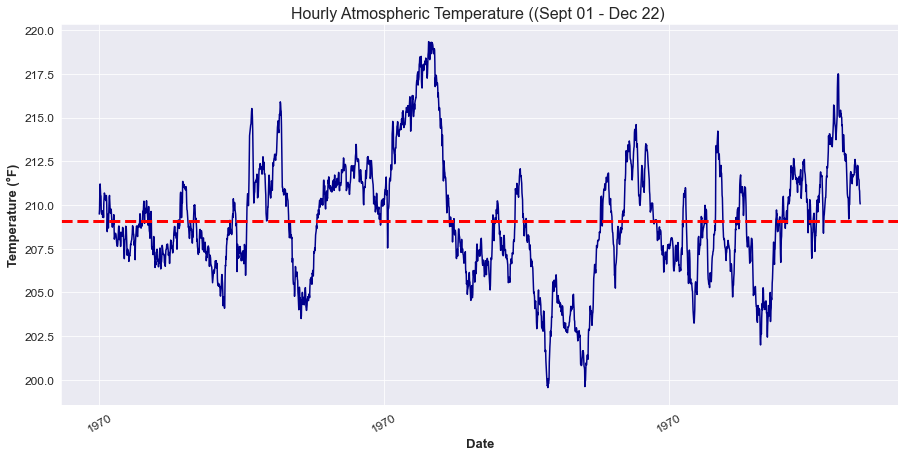

In [134]:
avg_TMP = combined_data['atm_TMP'].mean()

# Plot the temperature data for the entire dataset
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=combined_data['atm_TMP'], color='darkblue')
# Add the average line
plt.axhline(avg_TMP, color='red', linestyle='--', label='Average', lw='3')

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Temperature (°F)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hourly Atmospheric Temperature ((Sept 01 - Dec 22) ', fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()

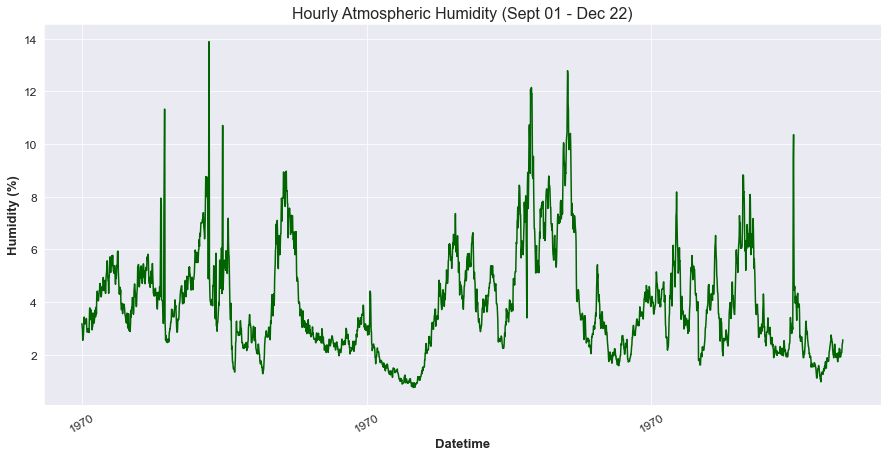

In [135]:
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=combined_data['Humidity'], color='darkgreen')
plt.xlabel('Datetime', fontsize=13, fontweight='bold')
plt.ylabel('Humidity (%)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hourly Atmospheric Humidity (Sept 01 - Dec 22)',  fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()

In [183]:
combined_data.set_index('Datetime', inplace=True)
combined_data.head(3)

,Latitude,Longitude,atm_TMP,Humidity,Pressure,atm_dewPt,Altitude (feet),grd_TMP,precp,humidity,...,dewPt,Image Present,Low/Mid Clouds (%),High Cirrus (%),Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-01 05:00:00,38.92868,-77.419229,209.477417,3.186864,18499.99771,287.126877,40186.999,68.0,0.0,65.0,...,56.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 06:00:00,38.92868,-77.419229,209.747436,3.067529,18499.99771,286.674957,41635.182,63.0,0.0,78.0,...,56.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 07:00:00,38.92868,-77.419229,210.730987,2.938781,26399.99924,287.050629,42098.598,61.0,0.0,83.0,...,56.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [189]:
combined_data.index = pd.to_datetime(combined_data.index)
combined_data.head()
# Create a subset for 4-week span with midnight data
start_date = pd.Timestamp('2022-09-01 00:00:00')
end_date = start_date + pd.DateOffset(weeks=4)
midnight_subset = combined_data.between_time('00:00:00', '00:00:00').loc[start_date:end_date]
morning_subset = combined_data.between_time('06:00', '06:00').loc[start_date:end_date]
afternoon_subset = combined_data.between_time('12:00', '12:00').loc[start_date:end_date]
evening_subset = combined_data.between_time('18:00', '18:00').loc[start_date:end_date]


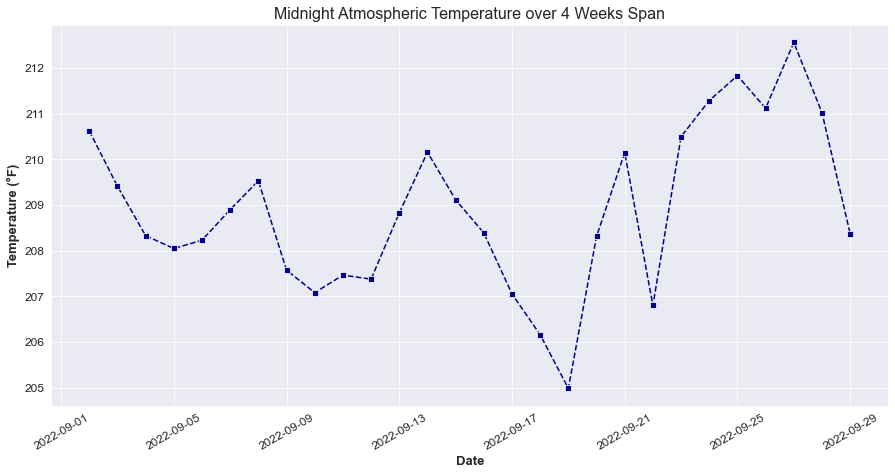

In [190]:
# Plot the temperature data
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=midnight_subset['atm_TMP'], color='darkblue', ls='dashed', marker='s')

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Temperature (°F)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Midnight Atmospheric Temperature over 4 Weeks Span', fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()

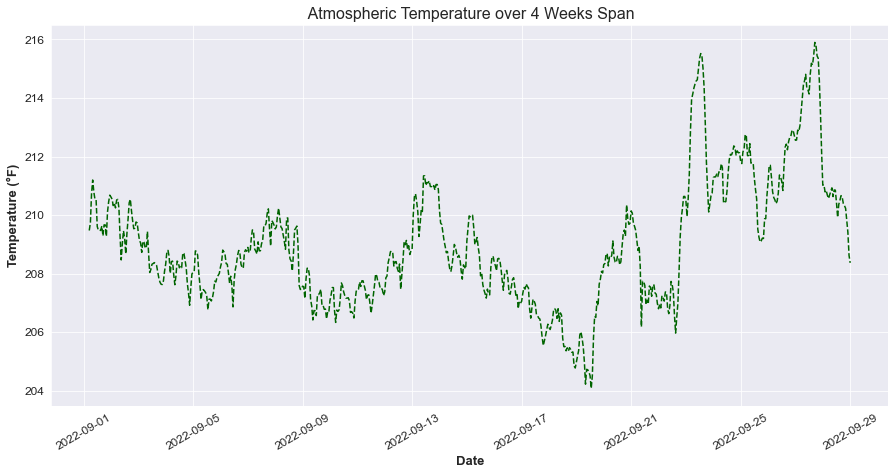

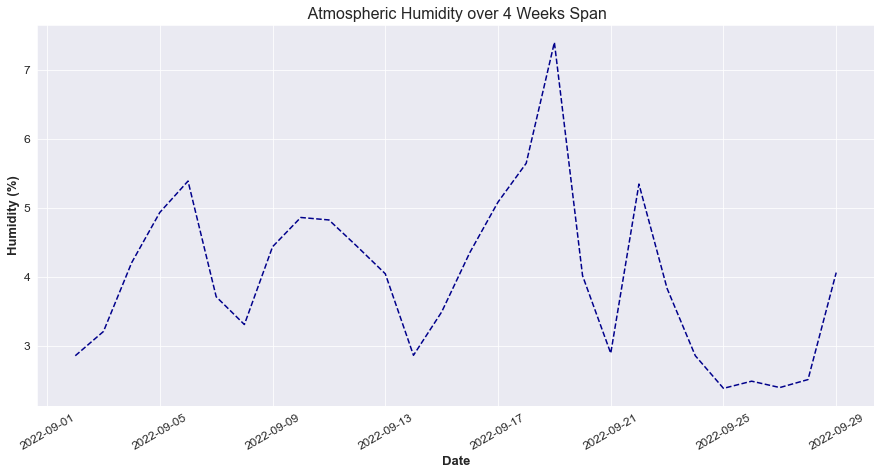

In [191]:
# Convert index to DatetimeIndex
combined_data.index = pd.to_datetime(combined_data.index)
#create a subset for 4 week spans 
start_date = pd.Timestamp('2022-09-01 00:00:00')
end_date = start_date + pd.DateOffset(weeks=4)
subset = combined_data.between_time('00:00', '23:00').loc[start_date:end_date]


# Plot the temperature data
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=subset['atm_TMP'], color='darkgreen', ls='dashed', marker='')

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Temperature (°F)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title(' Atmospheric Temperature over 4 Weeks Span', fontsize=16, fontweight='400', fontfamily='Arial')


# Plot the Humidity data
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=midnight_subset['Humidity'], color='darkblue', ls='dashed', marker='')

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Humidity (%)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title(' Atmospheric Humidity over 4 Weeks Span', fontsize=16, fontweight='400', fontfamily='Arial')


plt.show()

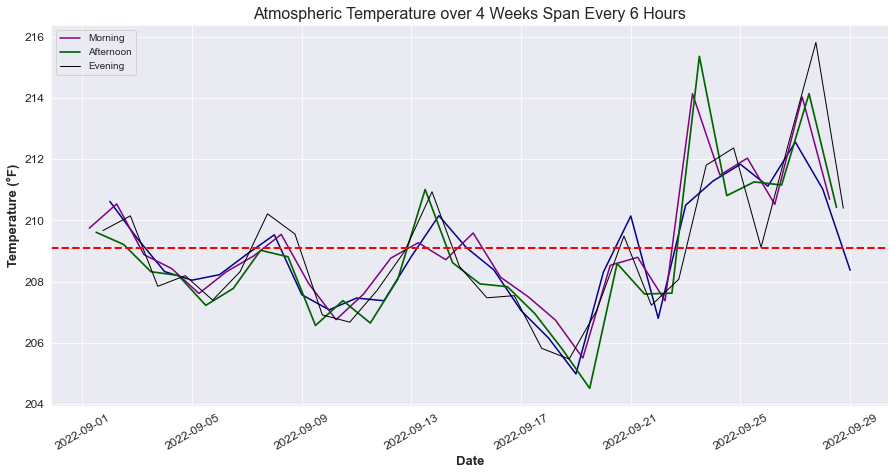

In [192]:
# Plot the temperature data
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=midnight_subset['atm_TMP'], color='darkblue')

sns.lineplot(data=morning_subset['atm_TMP'], color='purple', label='Morning', linestyle='solid' )
sns.lineplot(data=afternoon_subset['atm_TMP'], color='darkgreen', label='Afternoon', linestyle='solid', lw='1.7')
sns.lineplot(data=evening_subset['atm_TMP'], color='black', label='Evening', lw='1')
plt.axhline(avg_TMP, color='red', linestyle='--', label='Average', lw='2'
           )

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Temperature (°F)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Atmospheric Temperature over 4 Weeks Span Every 6 Hours', fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()